In [1]:
import pickle
data=None
with open('data_intervals.pkl', 'rb') as f:
    data = pickle.load(f)

In [60]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import *
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import random


def random_search(params, data, num_data_points=800, max_iter=100):
    results = []
    max_f1 = -np.inf
    best_params = None
    IDX=0
    
    if num_data_points==-1:
        num_data_points=len(data)
    
    for _ in range(max_iter):
        print(IDX)
        IDX+=1
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        f1_scores = []
        for i in range(num_data_points):
            DAT = data[list(data.keys())[i]]
            f1 = SCORE(DAT, **param_combination)
            f1_scores.append(f1)
        
        avg_f1 = np.mean(f1_scores)
        
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1


from functools import partial
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm


def random_search(params, data, num_data_points=800, max_iter=100):
    def evaluate(param_combination, data, num_data_points):
        f1_scores = np.array([SCORE(data[key], **param_combination) for key in random.sample(list(data.keys()), num_data_points)])
        return np.mean(f1_scores)

    if num_data_points == -1:
        num_data_points = len(data)

    best_params = None
    max_f1 = -np.inf
    results = []
    
    param_combinations = [dict(zip(params, x)) for x in np.array([np.random.choice(params[param], max_iter) for param in params]).T]

    with ThreadPoolExecutor(max_workers=9) as executor:
        partial_evaluate = partial(evaluate, data=data, num_data_points=num_data_points)
        # Wrap the executor.map with tqdm to display the progress bar
        f1_scores = list(tqdm(executor.map(partial_evaluate, param_combinations), total=max_iter))


    for idx, param_combination in enumerate(param_combinations):
        avg_f1 = f1_scores[idx]
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1


def get_dev(inA, inB, gran, metric):
    DEV = [
        metric(inA[i - gran:i], inB[i - gran:i]) if np.sum(inA[i - gran:i]) < np.sum(inB[i - gran:i]) else 0
        for i in range(gran, len(inA))
    ]
    return np.pad(DEV, (0, gran), 'edge')


import numpy as np
from scipy.spatial.distance import euclidean, cityblock, mahalanobis
from scipy.stats import skew, kurtosis
from sklearn.covariance import EmpiricalCovariance

def get_dev(inA, inB, gran, metric):
    DEV = [
        metric(inA[i - gran:i], inB[i - gran:i]) * np.sum(np.abs(inA[i - gran:i] - inB[i - gran:i])) if np.sum(inA[i - gran:i]) < np.sum(inB[i - gran:i]) else 0
        for i in range(gran, len(inA))
    ]
    return np.pad(DEV, (0, gran), 'edge')


def get_arr(V, quantile):
    Q = np.quantile(V, quantile)
    return np.where(V >= Q, 1, 0)

def get_intervals(seg, threshold):
    bool_array = seg >= threshold
    start_indices = np.where(np.logical_and(bool_array[:-1] == False, bool_array[1:] == True))[0]
    end_indices = np.where(np.logical_and(bool_array[:-1] == True, bool_array[1:] == False))[0]
    if bool_array[0]:
        start_indices = np.concatenate(([0], start_indices))
    if bool_array[-1]:
        end_indices = np.concatenate((end_indices, [len(seg) - 1]))
    return [(start_indices[i], end_indices[i]) for i in range(len(start_indices))]

from scipy.spatial.distance import dice





# def SCORE(DAT, gran=12, kernel_size=3, kernel_type='gaussian', quantile=0.7, threshold=0.15, metric=chebyshev, bias=0.0, coef1=0, coef2=0,coef3=0,shift=0):
# #     if kernel_type == 'gaussian':
# #         kernel = gaussian_kernel(kernel_size)
# #     elif kernel_type == 'laplacian':
# #         kernel = np.array([-1, 2, -1])
# #     elif kernel_type == 'sobel':
# #         kernel = np.array([-1, 0, 1])
# #     elif kernel_type == 'boxcar3':
# #         kernel = np.ones(3) / 3
# #     elif kernel_type == 'boxcar5':
# #         kernel = np.ones(5) / 5
# #     else:
# #         kernel = np.full(kernel_size, 1 / kernel_size)
#     kernel=[coef1,coef2,coef3][:kernel_size]
    
# #     kernel2=[coef11,coef22,coef33]#[:kernel_size]
# #         
# #     gran = 

# #     gran = 

#     day=DAT['day']
    
#     profile=DAT['profile']
    
# #     for i in range(kernel_size):
#     day = np.convolve(day, kernel, mode='same')
#     profile = np.convolve(profile, kernel, mode='same')
    
#     M = get_dev(day, profile, gran, chebyshev)
    
#     # step A
# #     M = (M * M) / (M * M).max()
#     chebSQ = np.power(M, quantile) + bias
    
# #     ARR = get_arr(M, quantile)
    
#     # step B
    
    
# #     chebSQ = np.convolve(chebSQ, kernel2, mode='same')
    
#     chebSQ = np.roll(chebSQ, shift)


#     # step C
#     seg = MinMaxScaler(feature_range=(0, 1)).fit_transform(chebSQ.reshape(-1, 1)).flatten()
    
#     seg = np.convolve(seg, kernel2, mode='same')

    
#     intervals = get_intervals(seg, threshold)
    
#     I1 = np.zeros(288)
#     for start, end in intervals:
#         I1[start:end] = 1

#     I2 = np.zeros(288)
#     start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
#     I2[start_idx:end_idx] = 1

#     return f1_score(I1, I2)
# #     return 1-dice(I1,I2)





import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

# def SCORE(DAT, gran=12, kernel_size=3, kernel_type='gaussian', quantile=0.7, threshold=0.15, metric=chebyshev, bias=0.0, coef1=0, coef2=0, coef3=0, coef4=0, coef11=0, coef22=0, coef33=0, shift=0):
#     kernel = [coef1, coef2, coef3][:kernel_size]
# #     kernel2 = [coef11, coef22, coef33]

#     day = DAT['day']
#     profile = DAT['profile']

#     day = np.convolve(day, kernel, mode='same')
#     profile = np.convolve(profile, kernel, mode='same')

#     M = get_dev(day, profile, gran, chebyshev)
#     chebSQ = np.power(M, quantile) + bias
#     chebSQ = np.roll(chebSQ, shift)

#     seg = MinMaxScaler(feature_range=(0, 1)).fit_transform(chebSQ.reshape(-1, 1)).flatten()
# #     seg = np.convolve(seg, kernel2, mode='same')

#     intervals = get_intervals(seg, threshold)

#     I1 = np.zeros(288)
#     for start, end in intervals:
#         I1[start:end] = 1

#     I2 = np.zeros(288)
#     start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
#     I2[start_idx:end_idx] = 1

#     return f1_score(I1, I2)



import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from scipy.signal import find_peaks

def boxcar_kernel(size):
    return np.ones(size) / size

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x = np.linspace(-size, size, 2*size + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    return g / g.sum()

metric_dict = {
    0: braycurtis,
    1: canberra,
    2: chebyshev,
    3: cityblock,
    4: correlation,
    5: cosine,
    6: euclidean,
    7: minkowski,
#     7: hamming,
    
#     9: seuclidean,
#     10: sqeuclidean,
#     11: dice
}

def SCORE(DAT, gran=12, kernel_size=3, threshold=0.5, selectivity=0.15,bias=0,metric=2, shift=0):
#     kernel = gaussian_kernel(kernel_size)
    kernel_size = int(kernel_size)
    bias=int(bias)
    gran=int(gran)
    shift=int(shift)
    metric=int(metric)
    
    kernel = np.full(kernel_size, 1 / kernel_size)

    day = DAT['day']
    profile = DAT['profile']

    day = np.convolve(day, kernel, mode='same')
    profile = np.convolve(profile, kernel, mode='same')

    M = get_dev(day, profile, gran, metric_dict[metric])
    chebSQ = np.power(M, selectivity)# + bias
    chebSQ = np.roll(chebSQ, shift)
    seg=chebSQ
    seg = MinMaxScaler(feature_range=(0, 1)).fit_transform(chebSQ.reshape(-1, 1)).flatten()
    intervals = get_intervals(seg, threshold)

    I1 = np.zeros(288)
    for start, end in intervals:
        I1[start:end] = 1

    I2 = np.zeros(288)
    start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
    I2[start_idx:end_idx] = 1

    return f1_score(I1, I2)


search_space = {
    'gran': np.arange(2, 48, 1),
    'kernel_size': [1,2,3,4,5,6,7,8],#np.arange(1, 5, 1),
    'threshold': np.linspace(0.01, 0.99, 512),
    'selectivity': np.linspace(0.01, 4.00, 512),
#     'metric': list(metric_dict.keys()),
#     'bias': np.linspace(-20, 20, 400),
    'shift': np.arange(-32,32,1),
#     'activation': [relu, sigmoid, tanh]
}

max_iterations = 800
results_df, best_params, best_f1 = random_search(search_space, data, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")

# Save results to a CSV file
results_df.to_csv('random_search_results.csv', index=False)

100%|██████████| 800/800 [52:38<00:00,  3.95s/it]  

Best parameters: {'gran': 21.0, 'kernel_size': 3.0, 'threshold': 0.41849315068493154, 'selectivity': 0.47068493150684937, 'shift': 11.0, 'f1_score': 0.6080092965294428}
Best f1_score: 0.6080092965294428


In [69]:
results_df['kernel_size'] = results_df['kernel_size'].astype(int)
results_df['gran'] = results_df['gran'].astype(int)

In [78]:
results_df[results_df.kernel_size<5]['f1_score'].max()

0.6080092965294428

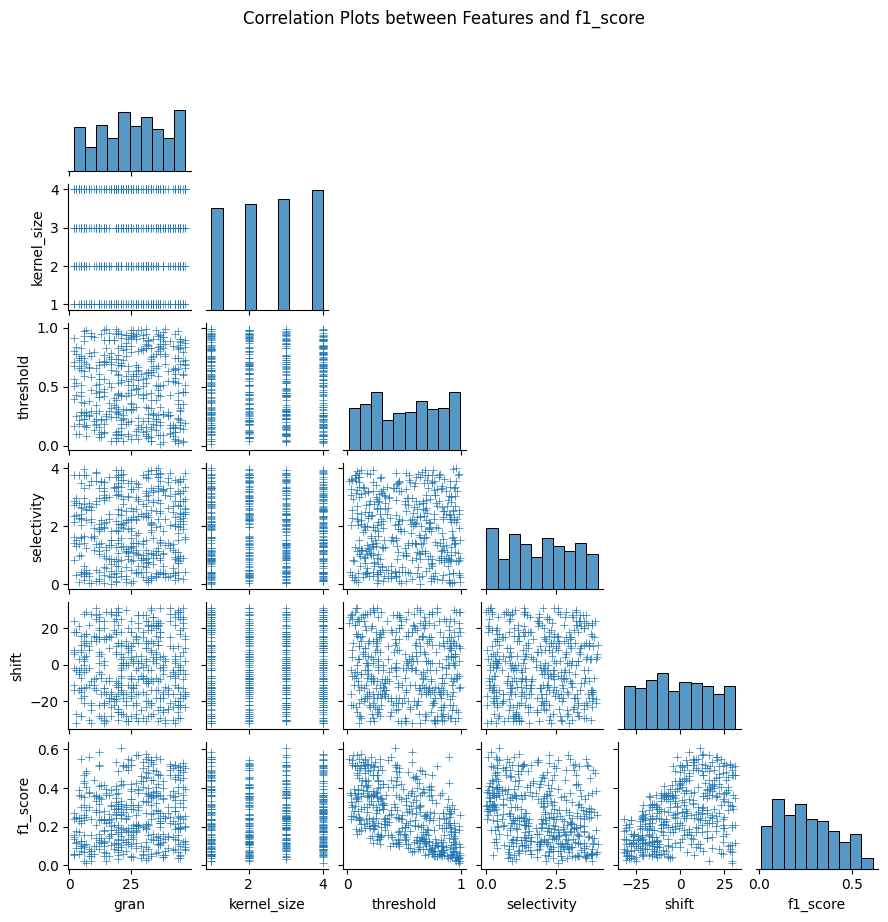

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a smaller pair plot using seaborn
g = sns.pairplot(results_df[results_df.kernel_size<5].sort_values(by='f1_score')[::], markers='+', corner=True, height=1.5)
# g.map_lower(sns.kdeplot, levels=4, color=".4")

# Set the title for the pair plot
g.fig.suptitle("Correlation Plots between Features and f1_score", y=1.02)

# Save the plot as a PDF
g.savefig('correlation_plots-cheb.pdf', format='pdf', bbox_inches='tight')

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from deap import base, creator, tools, algorithms
import random
import pandas as pd

# Your SCORE function definition...

# Evaluation function for DEAP
def eval_params(individual):
    params = {
        'gran': individual[0],
        'kernel_size': individual[1],
        'quantile': individual[2],
        'selectivity': individual[3],
        'metric': individual[4],
        'shift': individual[5]
    }
    return SCORE(data, **params),

# Setting up the DEAP framework for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("gran", random.choice, search_space['gran'])
toolbox.register("kernel_size", random.choice, search_space['kernel_size'])
toolbox.register("quantile", random.choice, search_space['quantile'])
toolbox.register("selectivity", random.choice, search_space['selectivity'])
toolbox.register("metric", random.choice, search_space['metric'])
toolbox.register("shift", random.choice, search_space['shift'])

# Define individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.gran, toolbox.kernel_size, toolbox.quantile,
                  toolbox.selectivity, toolbox.metric, toolbox.shift), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation function, crossover, mutation, and selection
toolbox.register("evaluate", eval_params)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Main function to run the Genetic Algorithm
def mainT():
    random.seed(42)
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40,
                                       stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof

if __name__ == "__main__":
    pop, logbook, hof = mainT()
    best_individual = tools.selBest(pop, 1)[0]
    best_params = {
        'gran': best_individual[0],
        'kernel_size': best_individual[1],
        'threshold': best_individual[2],
        'selectivity': best_individual[3],
        'metric': best_individual[4],
        'shift': best_individual[5]
    }
    best_f1 = best_individual.fitness.values[0]

    print(f"Best parameters: {best_params}")
    print(f"Best f1_score: {best_f1}")

    # Save


KeyError: 'day'

In [20]:
results_df

gran  kernel_size  quantile  selectivity  shift   
0     23            2  0.534646     0.603939      6  \
1     25            1  0.524747     0.247576      0   
2      5            4  0.257475     2.801515    -18   
3     31            5  0.930606     1.673030     11   
4     31            4  0.118889     1.168182      4   
5     30            1  0.099091     0.425758    -19   
6     31            4  0.831616     0.425758     18   
7     27            1  0.900909     0.425758     18   
8     25            5  0.396061     2.474848    -10   
9     16            2  0.188182     1.138485     -3   
10     3            5  0.108990     0.514848      0   
11    22            3  0.346566     0.544545    -11   
12    24            1  0.970202     1.880909     -9   
13    27            4  0.920707     2.920303    -19   
14    20            5  0.198081     1.346364     -3   

                                  activation  f1_score  
0      <function tanh at 0x000001C162D59510>  0.391989  
1   <function sigmoid at 0x000001C162D58820>  0.360039  
2      <function relu at 0x000001C1617FE440>  0.272561  
3      <function relu at 0x000001C1617FE440>  0.396576  
4      <function tanh at 0x000001C162D59510>  0.271354  
5      <function tanh at 0x000001C162D59510>  0.268885  
6      <function relu at 0x000001C1617FE440>  0.508572  
7      <function tanh at 0x000001C162D59510>  0.455603  
8   <function sigmoid at 0x000001C162D58820>  0.294300  
9      <function tanh at 0x000001C162D59510>  0.273175  
10     <function relu at 0x000001C1617FE440>  0.269254  
11     <function tanh at 0x000001C162D59510>  0.284675  
12     <function relu at 0x000001C1617FE440>  0.088983  
13     <function tanh at 0x000001C162D59510>  0.114975  
14     <function tanh at 0x000001C162D59510>  0.274216

In [13]:
!pip install deap


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import *
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from deap import base, creator, tools, algorithms

def evalScore(individual, data, num_data_points=300):
    param_combination = dict(zip(search_space.keys(), individual))
    f1_scores = []
    
    for i in range(num_data_points):
        DAT = data[list(data.keys())[i]]
        f1 = SCORE(DAT, **param_combination)
        f1_scores.append(f1)
    
    return np.mean(f1_scores),

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

for param_name, param_values in search_space.items():
    toolbox.register(param_name, random.choice, param_values)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.gran, toolbox.kernel_size, toolbox.kernel_type, toolbox.quantile,
                  toolbox.threshold, toolbox.bias, toolbox.coef1, toolbox.coef2, toolbox.coef3, toolbox.shift), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(search_space), indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalScore, data=data)

population_size = 50
num_generations = 10
pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations,
                                stats=stats, halloffame=hof, verbose=True)

best_individual = hof[0]
best_params = dict(zip(search_space.keys(), best_individual))
best_f1 = best_individual.fitness.values[0]

print("Best Params:", best_params)
print("Best F1 Score:", best_f1)


C:\Python3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Python3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg      	min	max     
0  	50    	0.0660194	0  	0.443105


UnboundLocalError: local variable 'kernel' referenced before assignment

In [20]:
best_individual = hof[0]
dict(zip(search_space.keys(), best_individual))

{'gran': 12,
 'kernel_size': 5,
 'kernel_type': 13,
 'quantile': 0.6407707707707707,
 'threshold': 1.616846846846847,
 'bias': 7,
 'coef1': 2,
 'coef2': 3,
 'coef3': 2.0989931392881394,
 'coef11': 1.4894361392780404,
 'coef22': 0.5182680302418929,
 'coef33': 6,
 'shift': 4}

In [11]:
results_df.sort_values(by='f1_score')

gran  kernel_size kernel_type  quantile  threshold       bias     coef1   
0     4            1    gaussian  0.686877   2.149520   5.905906  0.355307  \
1     3            1    gaussian  0.412202   2.031802 -20.000000  1.556543   
2    12            3    gaussian  0.177748   2.178949  -1.181181 -0.896475   
3    31            2    gaussian  0.559349   2.417327 -13.953954 -0.635846   
4    31            2    gaussian  0.857568   2.455586  15.075075  0.584203   
7     4            4    gaussian  0.762412   2.532102 -18.278278  0.807974   
8     4            3    gaussian  0.518148   2.950000 -15.715716  0.621825   
5    18            5    gaussian  0.625075   0.218949  17.797798  0.624418   
6    30            4    gaussian  0.094364   1.181291 -19.799800  0.003433   
9    24            1    gaussian  0.449479   0.360210  12.712713  0.286786   

      coef2     coef3    coef11    coef22    coef33  shift  f1_score  
0  0.401233  0.975211 -0.085148  0.310706  1.040533     17  0.000000  
1  0.607255  1.571498 -0.006679 -0.428625  0.838570     -2  0.000000  
2  1.470829  0.525384  1.039222 -0.787822  1.648158    -11  0.000000  
3 -0.606958  2.481062  0.912277  0.562239  0.823784     -8  0.000000  
4 -0.992310 -0.960217 -0.237034 -1.203572 -1.472661     13  0.000000  
7  0.275228 -0.322485 -0.610744 -0.243598  0.020554      7  0.000000  
8 -2.012194 -0.544355  0.828674  0.006698  2.563990      3  0.008256  
5 -0.450853 -1.414347  0.047644  2.036669 -0.438731    -20  0.185647  
6  1.237764 -0.441861  0.842107  1.927446  0.783880    -12  0.268397  
9 -1.983539 -2.021398  0.861660  1.546351  1.282306     -3  0.354753

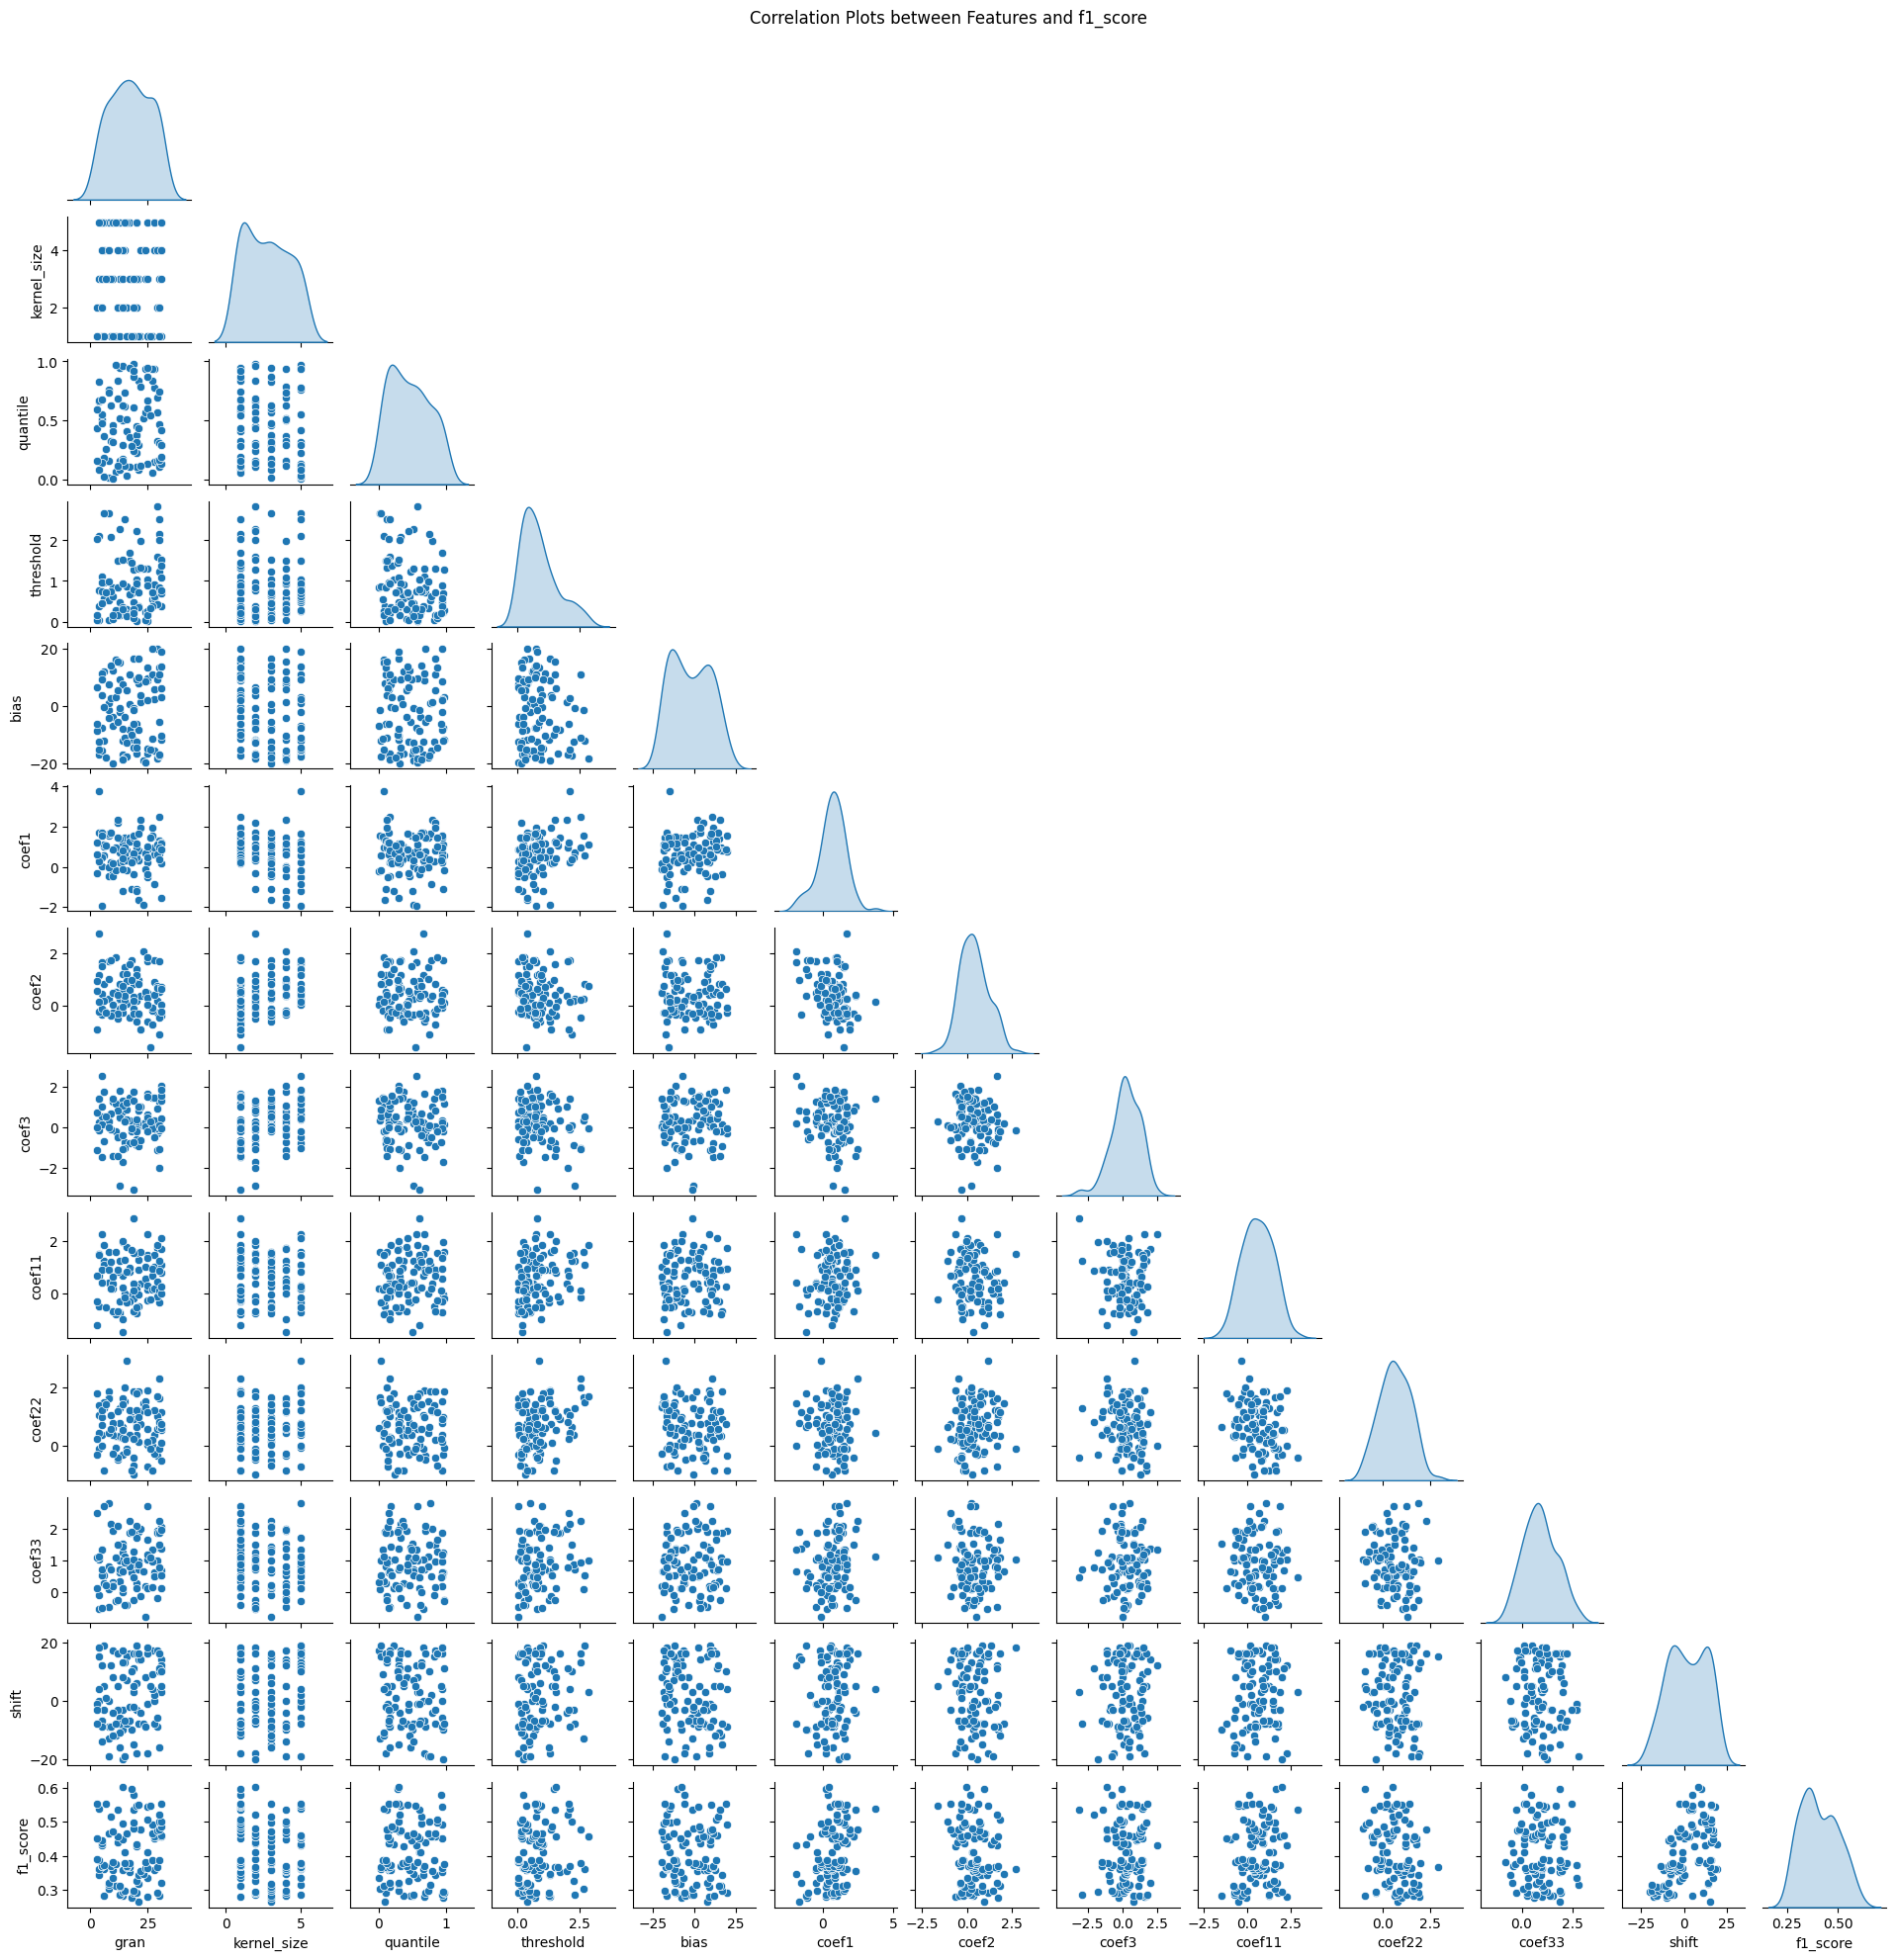

In [141]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

# Extract features and target from the DataFrame
X = results_df.drop('kernel_type',axis=1).drop(columns=['f1_score'])
y = results_df.drop('kernel_type',axis=1)['f1_score']

# Create an XGBRegressor model
dt_regressor = XGBRegressor(n_estimators=100)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Print the cross-validation scores and average score
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [-0.00610622 -0.00636312 -0.01282201 -0.0065281  -0.00571121 -0.01264007
 -0.01210986 -0.00819302 -0.00739574 -0.01232368]
Average cross-validation score: -0.009019302982236794


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


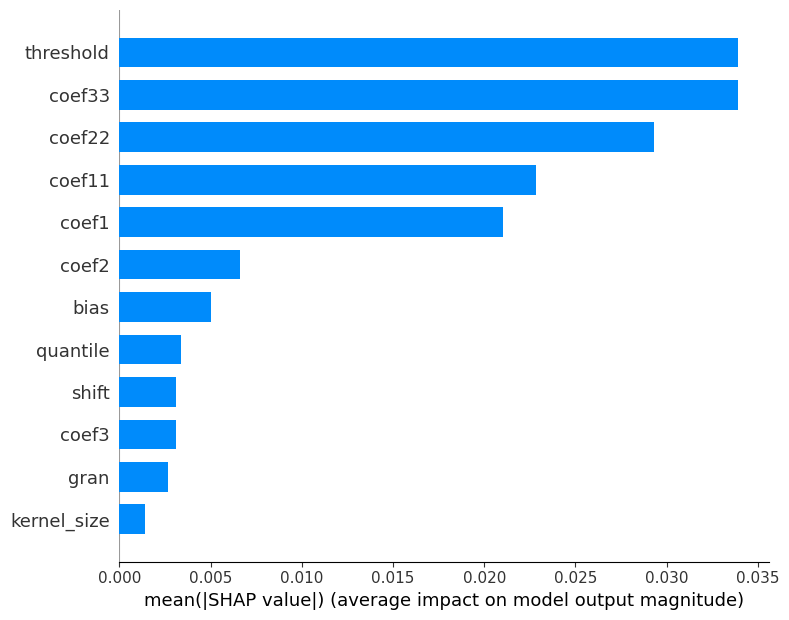

In [142]:
import shap
dt_regressor.fit(X,y)
# Create a SHAP explainer object
explainer = shap.TreeExplainer(dt_regressor)

# Compute SHAP values for the dataset
shap_values = explainer(X)

# Visualize feature importance using SHAP summary plot
shap.summary_plot(shap_values, X, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


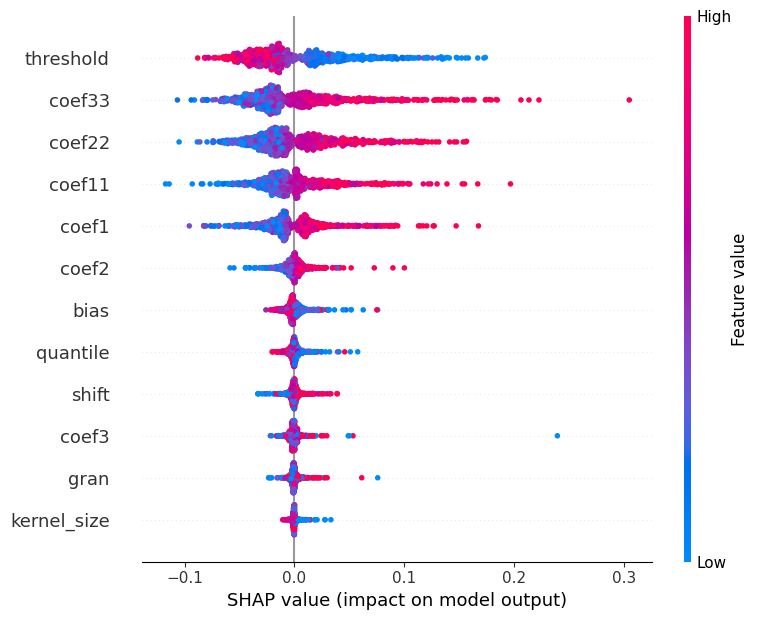

In [143]:
shap.summary_plot(shap_values, X)

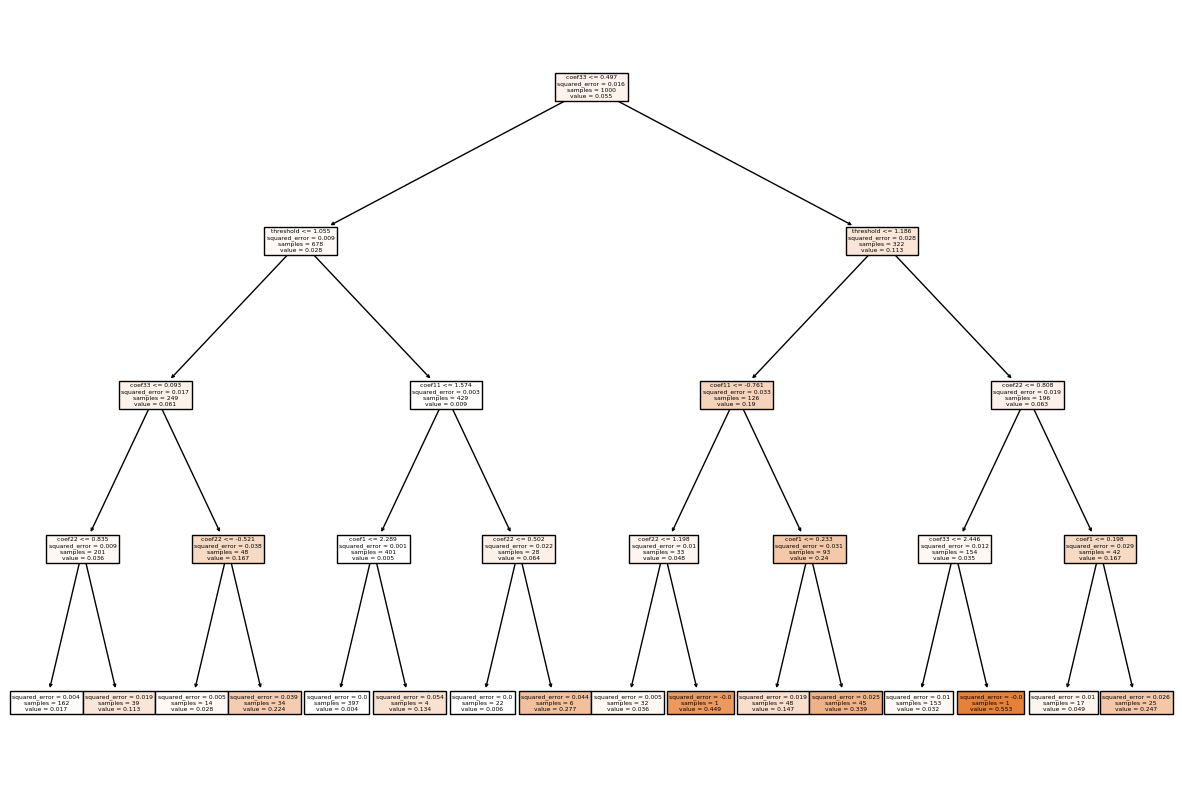

In [131]:
import graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
# Fit the decision tree model to the data with a maximum depth of 3
dt_regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_regressor.fit(X, y)

# Visualize the decision tree
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(dt_regressor, filled=True, feature_names=X.columns, ax=ax)

# Save the visualization as a PDF
plt.savefig('decision_tree_depth_3.pdf', format='pdf', bbox_inches='tight')

In [144]:
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

# Fit the decision tree model to the data with a maximum depth of 4
dt_regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_regressor.fit(X, y)

# Visualize the decision tree with Graphviz
dot_data = export_graphviz(
    dt_regressor,
    out_file=None,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=False,
    class_names=["Low", "Medium", "High"],  # Optional class labels for classification problems
    leaves_parallel=False,  # Toggle parallel edges for leaves
    node_ids=False,  # Toggle visibility of node IDs
    proportion=False,  # Toggle node color intensity with proportion of samples
    rotate=False,  # Rotate tree to left
    label=None,  # Label function to use for node texts
    precision=2,  # Number of decimal places to round to
#     fontsize=12,  # Font size for node texts
#     filled_leaf_nodes=True,  # Fill color for leaf nodes
#     colorscale=None,  # Colorscale for continuous target values
#     edge_color=None,  # Color for tree edges
#     edge_cmap=None,  # Colormap for tree edges
#     edge_vmin=None,  # Minimum value for colormap for tree edges
#     edge_vmax=None,  # Maximum value for colormap for tree edges
#     highlight_kws=None,  # Additional keyword arguments for highlighted nodes
)
# Perform 5-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_regressor, X, y, cv=kfold)

# Print the cross-validation scores and average score
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))
graph = graphviz.Source(dot_data)
graph.format = 'png'  # Change the output format
graph.render('decision_tree_depth_4', view=True)  # Save and open the tree visualization


Cross-validation scores: [ 0.24938808 -0.01042038  0.41012964 -0.14604922  0.44448639  0.1541201
  0.2163938   0.2111215  -0.07832443  0.04813142]
Average cross-validation score: 0.14989768914566678


'decision_tree_depth_4.png'

In [59]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import *
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import random


def random_search(params, data, num_data_points=200, max_iter=100):
    results = []
    max_f1 = -np.inf
    best_params = None
    IDX=0
    
    for _ in range(max_iter):
        print(IDX)
        IDX+=1
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        f1_scores = []
        for i in range(num_data_points):
            DAT = data[list(data.keys())[i]]
            f1 = SCORE(DAT, **param_combination)
            f1_scores.append(f1)
        
        avg_f1 = np.mean(f1_scores)
        
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1





def get_dev(inA, inB, gran, metric):
    DEV = [
        metric(inA[i - gran:i], inB[i - gran:i]) if np.sum(inA[i - gran:i]) < np.sum(inB[i - gran:i]) else 0
        for i in range(gran, len(inA))
    ]
    return np.pad(DEV, (0, gran), 'edge')


import numpy as np
from scipy.spatial.distance import euclidean, cityblock, mahalanobis
from scipy.stats import skew, kurtosis
from sklearn.covariance import EmpiricalCovariance

def get_dev(inA, inB, gran, metric):
    DEV = [
        metric(inA[i - gran:i], inB[i - gran:i]) * np.sum(np.abs(inA[i - gran:i] - inB[i - gran:i])) if np.sum(inA[i - gran:i]) < np.sum(inB[i - gran:i]) else 0
        for i in range(gran, len(inA))
    ]
    return np.pad(DEV, (0, gran), 'edge')


def get_arr(V, quantile):
    Q = np.quantile(V, quantile)
    return np.where(V >= Q, 1, 0)

def get_intervals(seg, threshold):
    bool_array = seg >= threshold
    start_indices = np.where(np.logical_and(bool_array[:-1] == False, bool_array[1:] == True))[0]
    end_indices = np.where(np.logical_and(bool_array[:-1] == True, bool_array[1:] == False))[0]
    if bool_array[0]:
        start_indices = np.concatenate(([0], start_indices))
    if bool_array[-1]:
        end_indices = np.concatenate((end_indices, [len(seg) - 1]))
    return [(start_indices[i], end_indices[i]) for i in range(len(start_indices))]

from scipy.spatial.distance import dice


import numpy as np
import pywt
from scipy.spatial.distance import euclidean

def haar_wavelet_distance(time_series_a, time_series_b):
    # Perform Haar wavelet decomposition on both time series
    coeffs_a = pywt.wavedec(time_series_a, 'haar')
    coeffs_b = pywt.wavedec(time_series_b, 'haar')

    # Calculate the distance between the wavelet coefficients
    distance = 0
    for coeff_a, coeff_b in zip(coeffs_a, coeffs_b):
        distance += euclidean(coeff_a, coeff_b)

    return distance



def SCORE(DAT, gran=12, kernel_size=3, kernel_type='gaussian', quantile=0.7, threshold=0.15, metric=chebyshev, step_A=True, step_B=True, step_C=True):
    if kernel_type == 'gaussian':
        kernel = gaussian_kernel(kernel_size)
    elif kernel_type == 'laplacian':
        kernel = np.array([-1, 2, -1])
    elif kernel_type == 'sobel':
        kernel = np.array([-1, 0, 1])
    elif kernel_type == 'boxcar3':
        kernel = np.ones(3) / 3
    elif kernel_type == 'boxcar5':
        kernel = np.ones(5) / 5
    else:
        kernel = np.full(kernel_size, 1 / kernel_size)
        
        

    M = get_dev(DAT['day'], DAT['profile'], gran, haar_wavelet_distance)

    if step_A:
        M = (M * M) / (M * M).max()

    ARR = get_arr(M, quantile)

    if step_B:
        chebSQ = np.convolve(ARR, kernel, mode='same')
    else:
        chebSQ = ARR

    if step_C:
        seg = MinMaxScaler(feature_range=(0, 1)).fit_transform(chebSQ.reshape(-1, 1)).flatten()
    else:
        seg = chebSQ

    intervals = get_intervals(seg, threshold)
    I1 = np.zeros(288)
    for start, end in intervals:
        I1[start:end] = 1

    I2 = np.zeros(288)
    start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
    I2[start_idx:end_idx] = 1

    return f1_score(I1, I2)

def boxcar_kernel(size):
    return np.ones(size) / size

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()


# ... (random_search and other functions)
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x = np.linspace(-size, size, 2*size + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    return g / g.sum()



# Define the parameter search space
search_space = {
    'gran': np.arange(6, 32, 1),
    'kernel_size': np.arange(1, 5, 1),
    'kernel_type': ['gaussian', 'laplacian', 'sobel', 'boxcar3', 'boxcar5'],
    'quantile': np.linspace(0.1, 0.9, 35),
    'threshold': np.linspace(0.1, 0.9, 35),
    'step_A': [True, False],
    'step_B': [True, False],
    'step_C': [True, False],
}

max_iterations = 50
results_df, best_params, best_f1 = random_search(search_space, data, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")

# Save results to a CSV file
results_df.to_csv('random_search_results.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Best parameters: {'gran': 8, 'kernel_size': 3, 'kernel_type': 'sobel', 'quantile': 0.7588235294117647, 'threshold': 0.31176470588235294, 'step_A': False, 'step_B': False, 'step_C': False, 'f1_score': 0.5004449206414262}
Best f1_score: 0.5004449206414262


ValueError: coefficient shape mismatch

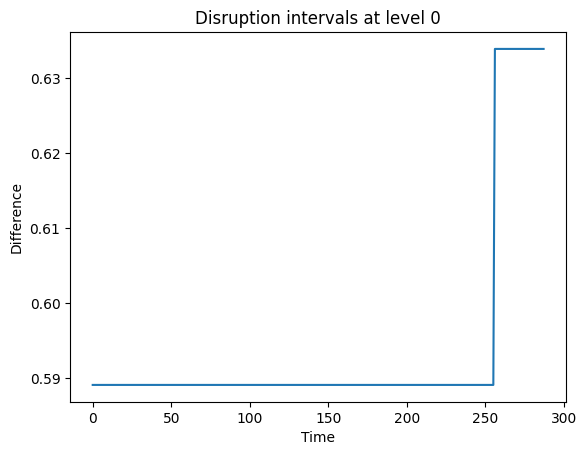

In [64]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def visualize_disruption_intervals(time_series_a, time_series_b):
    # Perform wavelet decomposition on both time series
    coeffs_a = pywt.wavedec(time_series_a, 'haar')
    coeffs_b = pywt.wavedec(time_series_b, 'haar')

    # Compute the difference between the wavelet coefficients
    coeffs_diff = [coeff_a - coeff_b for coeff_a, coeff_b in zip(coeffs_a, coeffs_b)]

    # Reconstruct the time series for each level of resolution and visualize
    for i, coeff_diff in enumerate(coeffs_diff):
        reconstructed_diff = pywt.waverec([coeff_diff] + [np.zeros_like(c) for c in coeffs_diff[i+1:]], 'haar')
        plt.figure()
        plt.plot(reconstructed_diff)
        plt.title(f"Disruption intervals at level {i}")
        plt.xlabel("Time")
        plt.ylabel("Difference")
    plt.show()

# Example time series
time_series_a = np.random.randn(100)
time_series_b = np.random.randn(100)

# Introduce a disruption interval in time_series_b
time_series_b[40:60] += 3

visualize_disruption_intervals(DAT['day'], DAT['profile'])


ValueError: coefficient shape mismatch

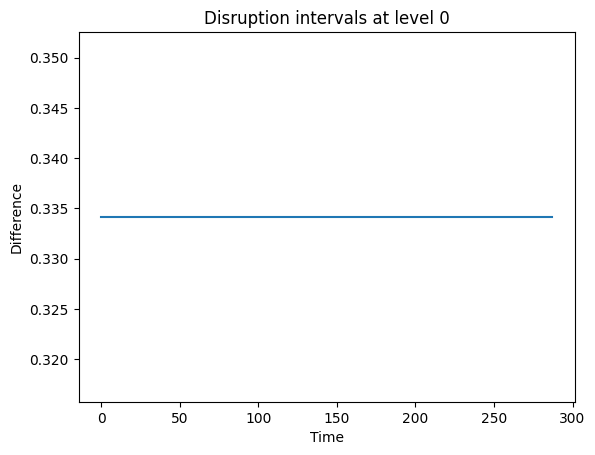

In [65]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def visualize_disruption_intervals(time_series_a, time_series_b):
    # Pad the input time series to the next higher power of 2
    length = len(time_series_a)
    padded_length = 2**int(np.ceil(np.log2(length)))
    time_series_a = np.pad(time_series_a, (0, padded_length - length), 'constant')
    time_series_b = np.pad(time_series_b, (0, padded_length - length), 'constant')

    # Perform wavelet decomposition on both time series
    coeffs_a = pywt.wavedec(time_series_a, 'haar')
    coeffs_b = pywt.wavedec(time_series_b, 'haar')

    # Compute the difference between the wavelet coefficients
    coeffs_diff = [coeff_a - coeff_b for coeff_a, coeff_b in zip(coeffs_a, coeffs_b)]

    # Reconstruct the time series for each level of resolution and visualize
    for i, coeff_diff in enumerate(coeffs_diff):
        reconstructed_diff = pywt.waverec([coeff_diff] + [np.zeros_like(c) for c in coeffs_diff[i+1:]], 'haar')
        # Truncate the output to the original length
        reconstructed_diff = reconstructed_diff[:length]
        plt.figure()
        plt.plot(reconstructed_diff)
        plt.title(f"Disruption intervals at level {i}")
        plt.xlabel("Time")
        plt.ylabel("Difference")
    plt.show()

# Example time series
time_series_a = np.random.randn(100)
time_series_b = np.random.randn(100)

# Introduce a disruption interval in time_series_b
time_series_b[40:60] += 3

visualize_disruption_intervals(DAT['day'], DAT['profile'])


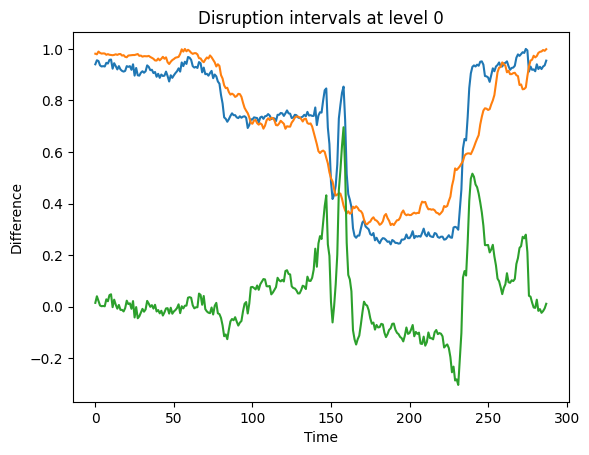

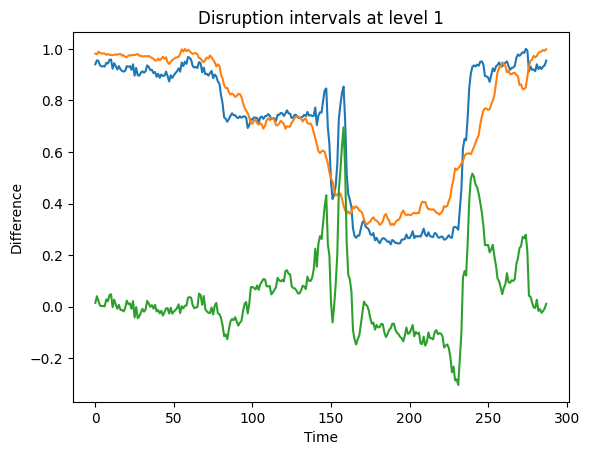

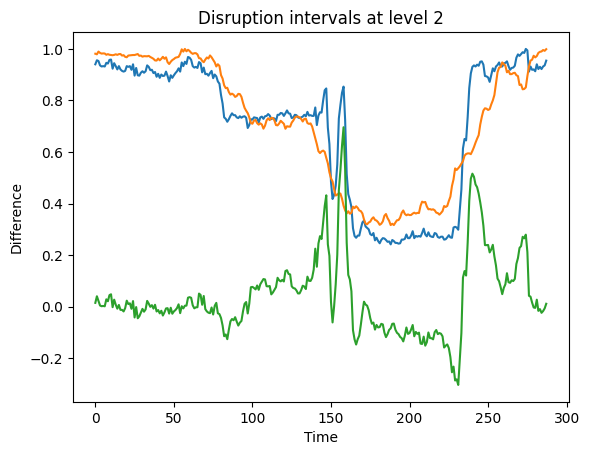

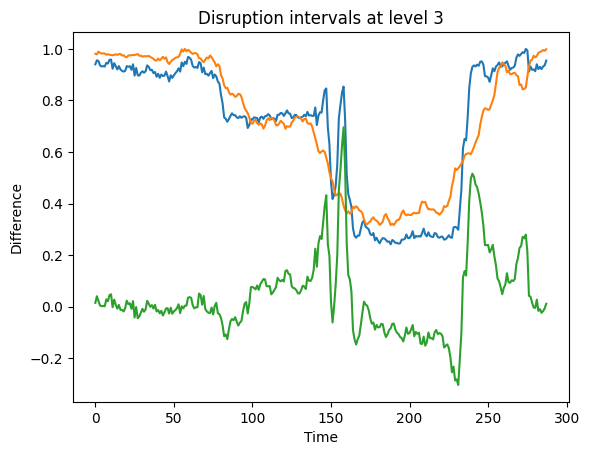

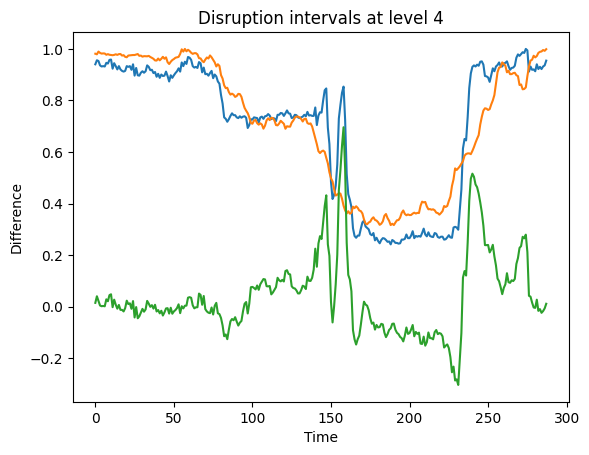

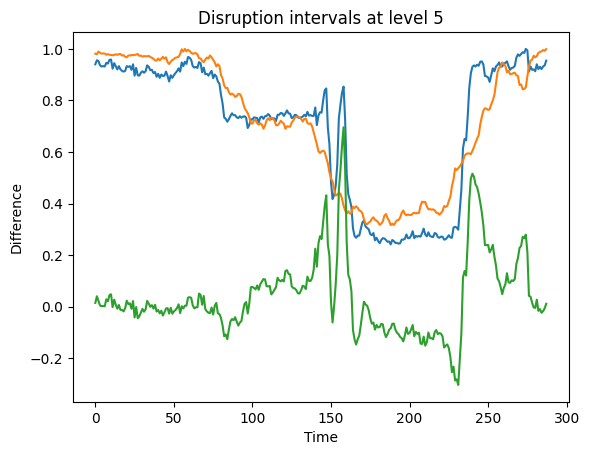

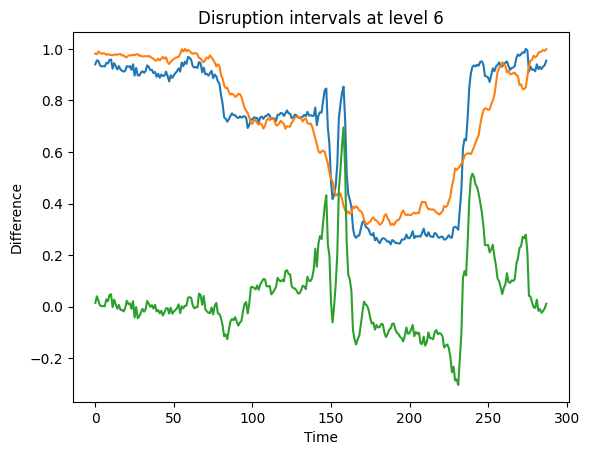

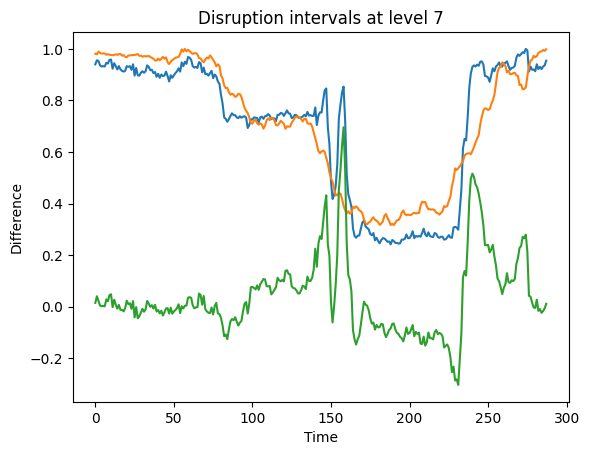

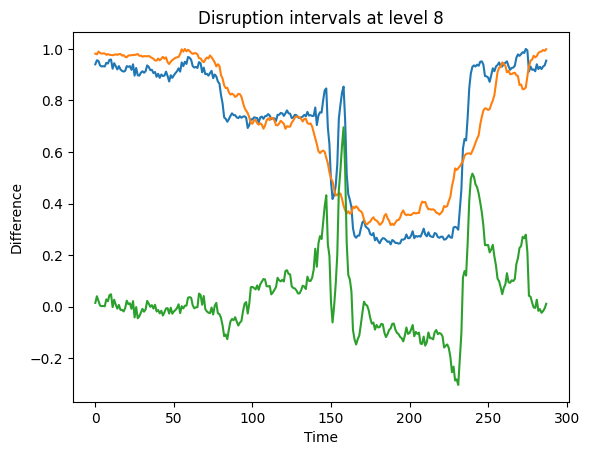

In [95]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import resample

def visualize_disruption_intervals(time_series_a, time_series_b):
    # Make sure both time series have the same length
    length = max(len(time_series_a), len(time_series_b))
    time_series_a = resample(time_series_a, length)
    time_series_b = resample(time_series_b, length)

    # Perform wavelet decomposition on both time series
    coeffs_a = pywt.wavedec(time_series_a, 'haar')
    coeffs_b = pywt.wavedec(time_series_b, 'haar')

    # Compute the difference between the wavelet coefficients
    coeffs_diff = [coeff_a - coeff_b for coeff_a, coeff_b in zip(coeffs_a, coeffs_b)]

    # Reconstruct the time series for each level of resolution and visualize
    for i, coeff_diff in enumerate(coeffs_diff):
#         A = [coeff_diff]
#         B = [np.zeros_like(c) for c in coeffs_diff[i+1:]]
#         print(np.array(A).shape, np.array(B).shape)
        reconstructed_diff =pywt.waverec(coeffs_diff , 'haar')
        plt.figure()
        plt.plot(time_series_a/time_series_a.max())
        plt.plot(time_series_b/time_series_b.max())
        plt.plot(reconstructed_diff/(reconstructed_diff.max() - reconstructed_diff.min()))
        plt.title(f"Disruption intervals at level {i}")
        plt.xlabel("Time")
        plt.ylabel("Difference")
    plt.show()

# Example time series
# time_series_a = np.random.randn(100)
# time_series_b = np.random.randn(100)

# Introduce a disruption interval in time_series_b
# time_series_b[40:60] += 3
DAT = data[list(data.keys())[73]]


# plt.plot(DAT['day']/DAT['day'].max())
visualize_disruption_intervals(DAT['day'], DAT['profile'])


{'ID': 'A-1029303',
 'day': array([56. , 55.8, 59. , 51.7, 52. , 54.3, 48.6, 49.9, 47.5, 46.9, 46.3,
        42.6, 43.7, 42.5, 38.4, 42.4, 40.6, 39.5, 35.6, 32.2, 33.1, 29.9,
        35.2, 34.2, 31.1, 33.9, 28.4, 40.2, 46. , 52.3, 56.6, 57.4, 57.7,
        56.8, 53.3, 46.7, 39.7, 42.8, 34. , 32.5, 33.1, 34. , 35.7, 38.2,
        35.4, 44.6, 37.5, 35. , 36.2, 39.3, 42.6, 42.8, 32.1, 54.8, 41.5,
        46.8, 47.5, 52.1, 53.5, 55.3, 52.3, 56. , 51.4, 58.5, 62.2, 57. ,
        58.6, 60.4, 53.6, 58.5, 53.9, 43.2, 40.7, 64.4, 63.4, 62.7, 60.7,
        60.4, 59. , 55. , 51.6, 40.6, 41.2, 41. , 44.6, 44.3, 45.2, 46. ,
        46.3, 44.8, 43.6, 39.4, 41.9, 38.6, 38.6, 38.7, 40. , 38.8, 38.3,
        36.3, 36.3, 37.5, 36.4, 35.8, 37.8, 36.2, 37.1, 36.6, 40.1, 40. ,
        41.9, 41. , 43.6, 40.2, 40.7, 40.3, 41.7, 40.7, 41.2, 40.1, 38.5,
        42.1, 42.4, 41.2, 41.8, 41.3, 39.3, 41.5, 41.3, 41.1, 42.7, 40.7,
        41.3, 42.8, 41. , 41.4, 42.8, 39.7, 41.8, 41.8, 40.1, 40.7, 40.1,
        41.

In [34]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import chebyshev
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import random

DAT = None

def random_search(params, data, num_data_points=100, max_iter=100):
    global DAT
    results = []
    max_f1 = -np.inf
    best_params = None
    IDX=0
    
    for _ in range(max_iter):
        print(IDX)
        IDX+=1
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        f1_scores = []
        for i in range(num_data_points):
            DAT = data[list(data.keys())[i]]
            f1 = haar_disruptions(DAT)
#             f1 = SCORE(DAT, **param_combination)
            f1_scores.append(f1)
        
        avg_f1 = np.mean(f1_scores)
        
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1





import numpy as np
from scipy.spatial.distance import euclidean, cityblock, mahalanobis
from scipy.stats import skew, kurtosis
from sklearn.covariance import EmpiricalCovariance

def get_dev(inA, inB, gran, metric):
    DEV = [
        metric(inA[i - gran:i], inB[i - gran:i]) * np.sum(np.abs(inA[i - gran:i] - inB[i - gran:i])) if np.sum(inA[i - gran:i]) < np.sum(inB[i - gran:i]) else 0
        for i in range(gran, len(inA))
    ]
    return np.pad(DEV, (0, gran), 'edge')





def get_arr(V, quantile):
    Q = np.quantile(V, quantile)
    return np.where(V >= Q, 1, 0)

def get_intervals(seg, threshold):
    bool_array = seg >= threshold
    start_indices = np.where(np.logical_and(bool_array[:-1] == False, bool_array[1:] == True))[0]
    end_indices = np.where(np.logical_and(bool_array[:-1] == True, bool_array[1:] == False))[0]
    if bool_array[0]:
        start_indices = np.concatenate(([0], start_indices))
    if bool_array[-1]:
        end_indices = np.concatenate((end_indices, [len(seg) - 1]))
    return [(start_indices[i], end_indices[i]) for i in range(len(start_indices))]

from scipy.signal import find_peaks

def SCORE(DAT, gran=12, kernel=3, quantile=0.7, threshold=0.15, metric=chebyshev):
    kernel = np.full(kernel, 1 / kernel)

    M = get_dev(DAT['day'], DAT['profile'], gran, metric)
    M = (M * M) / (M * M).max()

    ARR = get_arr(M, quantile)
    chebSQ = np.convolve(ARR, kernel, mode='same')

    seg = MinMaxScaler(feature_range=(0, 1)).fit_transform(chebSQ.reshape(-1, 1)).flatten()

    # Find the peaks in the seg signal
    peaks, _ = find_peaks(seg, prominence=threshold)

    I1 = np.zeros(288)
    for peak in peaks:
        start = max(0, peak - gran // 2)
        end = min(len(I1), peak + gran // 2)
        I1[start:end] = 1

    I2 = np.zeros(288)
    start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
    I2[start_idx:end_idx] = 1

    return f1_score(I1, I2)


# ... (random_search and other functions)

# Define the parameter search space
search_space = {
    'gran': np.arange(8, 24, 1),
    'kernel': np.arange(1, 5, 1),
    'quantile': np.linspace(0.5, 0.9, 15),
    'threshold': np.linspace(0.1, 0.3, 15),
    'metric': [chebyshev],
}

max_iterations = 50
results_df, best_params, best_f1 = random_search(search_space, data, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")

# Save results to a CSV file
results_df.to_csv('random_search_results.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Best parameters: {'gran': 20, 'kernel': 2, 'quantile': 0.5571428571428572, 'threshold': 0.2571428571428571, 'metric': <function chebyshev at 0x0000020B7FB9A710>, 'f1_score': 0.010178280877902195}
Best f1_score: 0.010178280877902195


In [28]:
!pip install PyWavelets

  Using cached PyWavelets-1.4.1-cp310-cp310-win_amd64.whl (4.2 MB)



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import numpy as np
import pywt
from sklearn.metrics import f1_score

In [35]:
def haar_disruptions(DAT, threshold=0.5):
    signal = DAT['profile']
    
    # Perform Haar wavelet decomposition
    coeffs = pywt.wavedec(signal, 'haar', level=4)

    # Threshold the wavelet coefficients
    thresholded_coeffs = [np.where(np.abs(c) > threshold, c, 0) for c in coeffs]

    # Reconstruct the signal from the thresholded coefficients
    reconstructed_signal = pywt.waverec(thresholded_coeffs, 'haar')

    # Determine the disruptions based on the difference between the original and reconstructed signals
    disruptions = np.where(np.abs(signal - reconstructed_signal) > threshold, 1, 0)

    # Compare the detected disruptions to the ground truth
    I1 = disruptions
    I2 = np.zeros(288)
    start_idx, end_idx = int(DAT['startM']), int(DAT['endM'])
    I2[start_idx:end_idx] = 1

    return f1_score(I1, I2)

In [38]:
haar_disruptions(DAT,0.9)

0.0

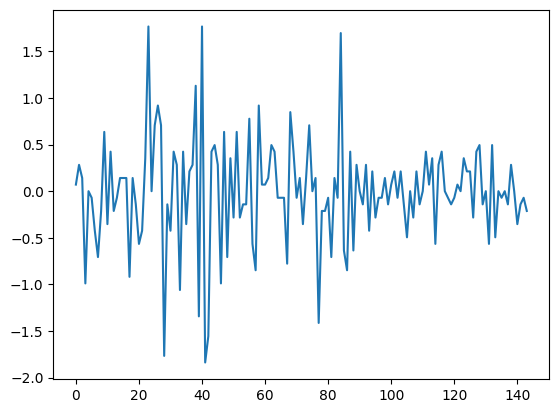

In [54]:
import matplotlib.pyplot as plt

plt.plot(pywt.wavedec(DAT['day'], 'haar', level=2)[2])

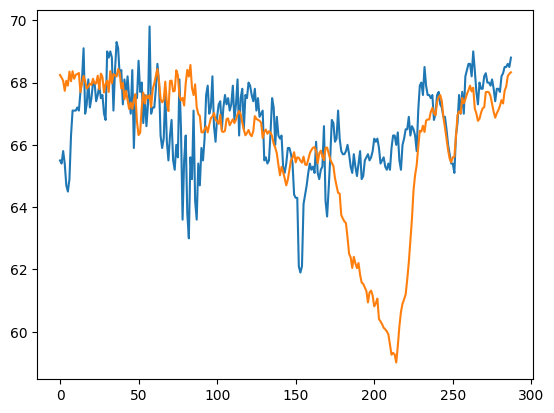

In [50]:
plt.plot(DAT['day'])
plt.plot(DAT['profile'])

In [55]:
import numpy as np
import pywt
from scipy.spatial.distance import euclidean

def haar_wavelet_distance(time_series_a, time_series_b):
    # Perform Haar wavelet decomposition on both time series
    coeffs_a = pywt.wavedec(time_series_a, 'haar')
    coeffs_b = pywt.wavedec(time_series_b, 'haar')

    # Calculate the distance between the wavelet coefficients
    distance = 0
    for coeff_a, coeff_b in zip(coeffs_a, coeffs_b):
        distance += euclidean(coeff_a, coeff_b)

    return distance

# Example time series
time_series_a = np.random.randn(100)
time_series_b = np.random.randn(100)

distance = haar_wavelet_distance(DAT['day'], DAT['profile'])
print(f"Distance between time series A and B: {distance}")


Distance between time series A and B: 108.0611174420042


In [40]:
DAT

{'ID': 'A-1415053',
 'day': array([65.5, 65.4, 65.8, 65.4, 64.7, 64.5, 64.9, 66.3, 67.1, 67.1, 67.1,
        67.2, 67.1, 67.7, 68.1, 69.1, 67. , 67.3, 68.1, 67.2, 67.5, 68. ,
        68. , 67.4, 67.6, 67.9, 67.5, 67.6, 67. , 66.8, 69. , 68.8, 69. ,
        68.8, 67.1, 68.4, 69.3, 69.1, 68.2, 68.4, 67.3, 68.1, 67.6, 68.2,
        67.5, 67. , 68.4, 65.9, 67.5, 67.5, 68.7, 67.7, 68. , 66.7, 67.6,
        66.6, 67.3, 69.8, 67. , 67.2, 67.2, 67.8, 68.6, 68. , 66.3, 65.9,
        66.2, 67.7, 66.1, 65.5, 66.3, 66.8, 65.5, 65.2, 66. , 65.6, 68.1,
        66.5, 63.6, 65.5, 66.3, 63.8, 63. , 65.6, 64.9, 67.1, 64.2, 63.6,
        65.4, 64.7, 65.9, 65.5, 66.2, 67.6, 67.9, 67. , 67.2, 68.2, 66.6,
        66.1, 66.9, 67.3, 67.4, 66.5, 67.2, 67.6, 67.3, 67.5, 67.1, 67.3,
        67.9, 66.8, 67.3, 68.1, 66.3, 67.5, 67.8, 66.5, 67.6, 67.5, 68. ,
        67.9, 67.6, 67.4, 67.8, 67.1, 67.5, 66.9, 67. , 67.1, 65.5, 65.6,
        65.4, 65.5, 66.4, 67.5, 67.2, 66. , 66.9, 66.3, 66.2, 66.3, 65.3,
        65.

In [8]:
results_df

gran  kernel  quantile  threshold  f1_score
0      8       2       0.8       0.20  0.511813
1      8       1       0.7       0.15  0.483668
2     16       4       0.9       0.15  0.430970
3     14       3       0.7       0.30  0.461447
4     18       4       0.5       0.15  0.340825
5     12       2       0.8       0.30  0.488447
6     14       4       0.6       0.30  0.410468
7     16       4       0.7       0.20  0.461201
8     10       4       0.9       0.15  0.464061
9     18       3       0.8       0.15  0.452560
10    10       1       0.7       0.30  0.477293
11    12       3       0.6       0.30  0.405646
12    12       1       0.8       0.20  0.479750
13    14       2       0.5       0.20  0.346685
14    14       3       0.9       0.10  0.421034
15     8       2       0.9       0.15  0.460601
16    16       1       0.7       0.20  0.458941
17     8       4       0.7       0.10  0.477238
18    18       1       0.8       0.30  0.446511
19    18       4       0.8       0.25  0.461116
20     8       4       0.6       0.25  0.413838
21    14       4       0.5       0.25  0.342836
22    10       4       0.8       0.25  0.501915
23    18       2       0.5       0.20  0.342687
24     8       2       0.9       0.30  0.460601
25    14       2       0.6       0.10  0.410007
26    10       2       0.8       0.25  0.498967
27    12       1       0.6       0.20  0.385192
28    12       1       0.5       0.15  0.271300
29     8       4       0.9       0.15  0.478916
30    16       1       0.6       0.25  0.383024
31    18       4       0.7       0.25  0.449993
32     8       4       0.6       0.20  0.413838
33    10       4       0.7       0.25  0.472838
34    18       2       0.5       0.15  0.342687
35    10       3       0.7       0.15  0.471371
36    14       2       0.7       0.20  0.468037
37    14       4       0.8       0.10  0.483696
38    12       2       0.5       0.20  0.349886
39    14       2       0.9       0.10  0.419838
40    12       3       0.8       0.30  0.484201
41    14       4       0.9       0.30  0.419889
42    10       2       0.5       0.15  0.350210
43    14       3       0.6       0.30  0.404582
44    14       3       0.7       0.10  0.461447
45    14       3       0.9       0.25  0.421034
46    18       3       0.7       0.20  0.445454
47     8       1       0.5       0.20  0.264240
48    10       2       0.7       0.30  0.479210
49    16       3       0.9       0.25  0.416815

In [2]:
data['A-10030']['day']
data['A-10030']['profile']
print()
data['A-10030']

{'ID': 'A-10030',
 'day': array([66.7, 67.5, 68.2, 67.2, 65.4, 64.9, 65.5, 66.9, 65.4, 63.2, 63.8,
        64.6, 64.7, 65.3, 63.9, 62.6, 64.9, 64.4, 60.7, 62.1, 62.2, 61.3,
        63.4, 64.9, 66.4, 66.5, 65.9, 65.9, 66. , 65.6, 65.4, 65.2, 65.1,
        65.6, 63.8, 64.6, 63.9, 65.4, 65.6, 65.7, 64.3, 62.7, 63.9, 65.2,
        64.8, 63.1, 63.7, 65.6, 62.8, 64.3, 62. , 63.3, 63.6, 64. , 63.7,
        63.9, 67.8, 66. , 67.8, 66. , 66.4, 63.7, 68.3, 67.5, 66.2, 68.5,
        67.8, 65.3, 64.3, 64. , 64.1, 64.6, 60.1, 62.7, 62.9, 62.2, 62.2,
        60.2, 59.5, 57. , 53.6, 52.2, 50.2, 49.7, 48. , 46.8, 45.8, 45.2,
        46.8, 46.8, 47.8, 48.2, 47.5, 48.9, 48. , 49. , 48.8, 46.5, 44.7,
        45.6, 45. , 47.6, 46.1, 46.4, 46.1, 46.8, 48. , 46.5, 44.5, 44.1,
        44.5, 45.6, 46.7, 44.2, 43.1, 43.6, 44.5, 43.1, 43.7, 44.5, 43.3,
        44. , 43.6, 44.6, 44.6, 44.5, 45.5, 45.1, 44.6, 45. , 46.3, 45.7,
        45.2, 44.6, 44.1, 44.8, 46.8, 46.2, 47. , 48.6, 48.7, 50.1, 47.3,
        48.4,

In [3]:
from scipy.spatial.distance import *
import matplotlib.pyplot as plt

import numpy as np

def getABS(seg,threshold = 0.15):
    """Finds intervals in a sequence where values are positive and greater than a threshold.

    Args:
        seg (numpy.ndarray): A 1D numpy array containing the sequence to search.
        threshold (float): The threshold value to use for identifying positive intervals.

    Returns:
        A list of tuples, where each tuple represents an interval in the sequence where values
        are positive and greater than the threshold. Each tuple has the form (start_index, end_index).
    """
    
    bool_array = seg >= threshold
    start_indices = np.where(np.logical_and(bool_array[:-1] == False, bool_array[1:] == True))[0]
    end_indices = np.where(np.logical_and(bool_array[:-1] == True, bool_array[1:] == False))[0]
    if bool_array[0]:
        start_indices = np.concatenate(([0], start_indices))
    if bool_array[-1]:
        end_indices = np.concatenate((end_indices, [len(seg)-1]))
    intervals = [(start_indices[i], end_indices[i]) for i in range(len(start_indices))]
    
    return intervals



from scipy.stats import wasserstein_distance as WD
def METRIC(inA,inB,metric=WD,gran=12):
    DEV=[]
    

    for i in range(gran,len(inA)):
        A = inA[i-gran:i]
        B = inB[i-gran:i]
#         print(A.shape,B.shape)
        res = metric(A,B)
        
        # Assumption #1: accident represents a drop in traffic speed
        if np.sum(A)<np.sum(B):
            DEV.append(res)
        else:
            DEV.append(0)

    lst=DEV[-1]
    for i in range(gran):
        DEV.append(lst)
        
    DEV = np.array(DEV)
    return DEV

def qfilter(V,quantile=0.96):
    Q = np.quantile(V,quantile)
    ARR=[]
    for i in range(len(V)):
        if V[i]>=Q:
            ARR.append(1)
        else:
            ARR.append(0)
    return np.array(ARR)


from sklearn.preprocessing import MinMaxScaler
def standard_scale(input_vector):
    """
    This function performs standard scaling between 0 and 1 of an input vector.
    
    Args:
    input_vector (list or numpy array): The input vector to be scaled.
    
    Returns:
    numpy array: The scaled input vector.
    """
    
    # Create a MinMaxScaler object
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Reshape the input vector to a 2D array with one column
    input_vector_reshaped = [[x] for x in input_vector]

    # Use the scaler to perform the standard scaling
    scaled_input_vector = scaler.fit_transform(input_vector_reshaped)

    # Return the scaled input vector
    return scaled_input_vector.flatten()



from scipy.spatial.distance import *
import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance as WD

import numpy as np

def f1_score(arr1, arr2):
    # Calculate true positives, false positives, and false negatives
    tp = np.sum(np.logical_and(arr1 == 1, arr2 == 1))
    fp = np.sum(np.logical_and(arr1 == 0, arr2 == 1))
    fn = np.sum(np.logical_and(arr1 == 1, arr2 == 0))

    # Calculate precision and recall
    precision = tp / (tp + fp+0.00001)
    recall = tp / (tp + fn+0.00001)

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall+0.0001)

    return f1


import numpy as np


def I2A(intervals,length=288):
    # Create an array of zeros with length 288
    arr = np.zeros(length)

    # Check if the input is a list of intervals or a single interval
    if isinstance(intervals, list):
        # Iterate over each interval
        for start, end in intervals:
            # Convert the start and end times to indices in the array
            start_idx = int(start)
            end_idx = int(end)

            # Set the values in the array to 1 for the points inside the interval
            arr[start_idx:end_idx] = 1
    elif isinstance(intervals, tuple):
        # Convert the start and end times to indices in the array
        start_idx = int(intervals[0])
        end_idx = int(intervals[1])

        # Set the values in the array to 1 for the points inside the interval
        arr[start_idx:end_idx] = 1
    else:
        raise ValueError("Intervals must be a list or a tuple")

    return arr

# F1 = []
# for i in range(len(res)):
#     row = res.iloc[i]
#     F1.append(f1_score(I2A((row.startM, row.endM)), I2A(row.intervals)))

import warnings
def SQ(inA, inB, gran=12,kernel=[0.25,0.25,0.25,0.25],quantile=0.7,threshold=0.15):
    day = inA
    profile=inB
    M = METRIC(day,profile, chebyshev, gran=gran)
    
    with warnings.catch_warnings():
            
        warnings.filterwarnings('error', category=RuntimeWarning)
        M = (M*M)/(M*M).max()
        chebSQ = np.convolve(qfilter(M,quantile),kernel)
        
        return getABS(standard_scale(chebSQ),threshold=threshold)
    
DAT = data['A-1395360']

def SCORE(DAT, gran=12,kernel=3,quantile=0.7,threshold=0.15):
    
    if kernel==1:
        kernel=np.array([1.0])
    elif kernel==2:
        kernel=np.array([0.5,0.5])
    elif kernel==3:
        kernel=np.array([0.33,0.33,0.33])
    elif kernel==4:
        kernel=np.array([0.25,0.25,0.25,0.25])
    
    ARRAYSQ = SQ(DAT['day'],DAT['profile'],gran,kernel,quantile,threshold)

    I1 = I2A(ARRAYSQ)
    I2 = I2A((DAT['startM'],DAT['endM']))
    return f1_score(I1,I2)


In [4]:
import numpy as np
from itertools import product
from sklearn.metrics import f1_score

# Your existing functions here

# ... (SQ and SCORE functions)

import pandas as pd
from itertools import product
from sklearn.metrics import f1_score

# Your existing functions here

# ... (SQ and SCORE functions)

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import random

# Your existing functions here

# ... (SQ and SCORE functions)



def random_search(params, max_iter=100):
    results = []
    max_f1 = -np.inf
    best_params = None

    for _ in range(max_iter):
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        DAT = data['A-1395360']
        
        f1 = SCORE(DAT, **param_combination)
        
        param_combination["f1_score"] = f1
        results.append(param_combination)

        if f1 > max_f1:
            max_f1 = f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1

# Define the parameter search space
search_space = {
    'gran': np.arange(8, 20, 2),
    'kernel': np.arange(1, 5, 1),
    'quantile': np.linspace(0.5, 0.9, 5),
    'threshold': np.linspace(0.1, 0.3, 5),
}

max_iterations = 50
results_df, best_params, best_f1 = random_search(search_space, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")

# Save results to a CSV file
results_df

# # Save results to a CSV file
# results_df


Best parameters: {'gran': 10, 'kernel': 3, 'quantile': 0.7, 'threshold': 0.3, 'f1_score': 0.5882352941176471}
Best f1_score: 0.5882352941176471


gran  kernel  quantile  threshold  f1_score
0     18       2       0.7       0.10  0.503817
1     14       4       0.6       0.10  0.243902
2      8       1       0.6       0.15  0.000000
3     14       2       0.9       0.10  0.564103
4     16       4       0.7       0.20  0.539007
5     10       1       0.6       0.10  0.000000
6     10       4       0.6       0.15  0.243902
7      8       3       0.6       0.15  0.243902
8     16       4       0.5       0.10  0.243902
9     14       3       0.5       0.15  0.243902
10    10       4       0.6       0.15  0.243902
11    14       3       0.6       0.15  0.243902
12    16       3       0.9       0.15  0.547619
13    18       4       0.6       0.10  0.496894
14    18       4       0.7       0.30  0.519084
15    10       3       0.7       0.30  0.588235
16    12       1       0.8       0.10  0.576923
17    14       4       0.6       0.10  0.243902
18    18       3       0.8       0.10  0.433962
19    18       3       0.7       0.25  0.503704
20    18       2       0.9       0.20  0.511628
21    12       4       0.6       0.10  0.243902
22    12       2       0.8       0.10  0.574074
23    12       3       0.6       0.15  0.243902
24    16       4       0.6       0.10  0.496894
25    18       4       0.8       0.15  0.440367
26     8       2       0.5       0.10  0.244648
27    18       1       0.5       0.10  0.000000
28    18       3       0.5       0.15  0.243902
29    10       4       0.8       0.15  0.563636
30    14       2       0.6       0.25  0.244648
31    18       4       0.7       0.30  0.519084
32    18       1       0.8       0.10  0.420000
33    14       4       0.7       0.30  0.552239
34     8       1       0.5       0.10  0.000000
35    18       3       0.9       0.25  0.522727
36    10       4       0.6       0.10  0.243902
37    14       1       0.7       0.10  0.538462
38     8       3       0.9       0.30  0.461538
39    16       4       0.6       0.30  0.509554
40    12       4       0.6       0.15  0.243902
41    14       4       0.6       0.15  0.243902
42    14       1       0.8       0.20  0.420000
43    12       1       0.5       0.25  0.000000
44    18       3       0.9       0.30  0.522727
45    16       1       0.5       0.20  0.000000
46    12       1       0.8       0.10  0.576923
47    14       3       0.5       0.30  0.243902
48    14       3       0.7       0.15  0.536232
49    12       4       0.5       0.10  0.243902

In [26]:
def SCORE(DAT, **params):
    ARRAYSQ = SQ(DAT['day'], DAT['profile'], **params)

    I1 = I2A(ARRAYSQ)
    I2 = I2A((DAT['startM'], DAT['endM']))
    return f1_score(I1, I2)

def random_search(params, data, num_data_points=100, max_iter=100):
    results = []
    max_f1 = -np.inf
    best_params = None
    IDX=0
    
    for _ in range(max_iter):
        print(IDX)
        IDX+=1
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        f1_scores = []
        for i in range(num_data_points):
            DAT = data[list(data.keys())[i]]
            f1 = SCORE(DAT, **param_combination)
            f1_scores.append(f1)
        
        avg_f1 = np.mean(f1_scores)
        
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1

# Define the parameter search space
search_space = {
    'gran': np.arange(8, 25, 1),
    'kernel': np.arange(1, 5, 1),
    'quantile': np.linspace(0.5, 0.95, 30),
    'threshold': np.linspace(0.05, 0.5, 30),
}

max_iterations = 300
num_data_points = 820
results_df, best_params, best_f1 = random_search(search_space, data, num_data_points=num_data_points, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")

# Save results to a CSV file
results_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

gran  kernel  quantile  threshold  f1_score
0       8       2  0.655172   0.065517  0.457052
1       8       3  0.903448   0.360345  0.442276
2      20       3  0.655172   0.468966  0.414315
3      21       2  0.872414   0.453448  0.418657
4      16       1  0.717241   0.220690  0.466400
..    ...     ...       ...        ...       ...
295    16       1  0.779310   0.344828  0.464638
296    13       1  0.794828   0.065517  0.476853
297    24       3  0.608621   0.081034  0.363728
298    24       1  0.531034   0.282759  0.293082
299    11       1  0.546552   0.189655  0.325956

[300 rows x 5 columns]

In [7]:
results_df.to_csv('iters.csv')

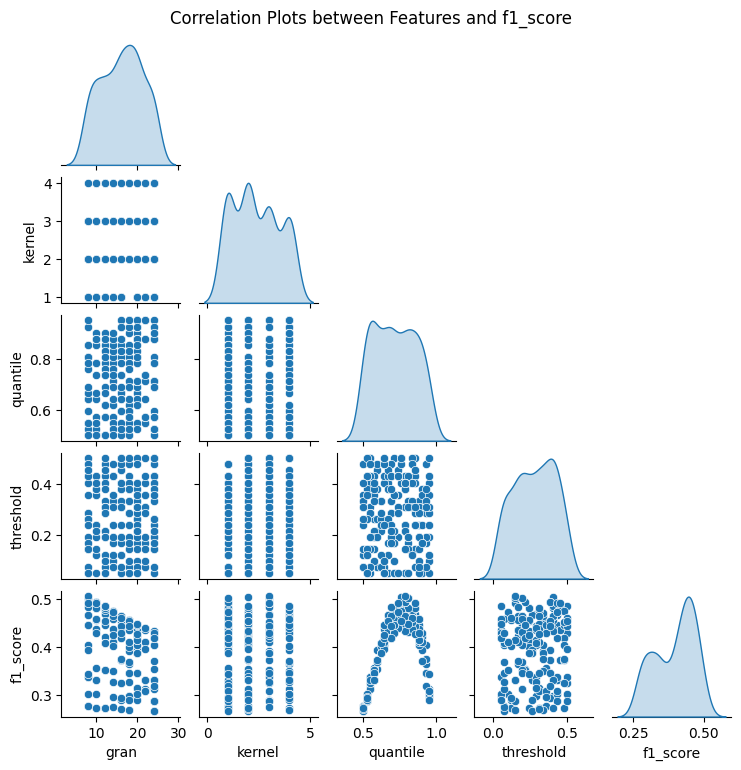

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a smaller pair plot using seaborn
g = sns.pairplot(results_df, diag_kind='kde', markers='o', corner=True, height=1.5)

# Set the title for the pair plot
g.fig.suptitle("Correlation Plots between Features and f1_score", y=1.02)

# Save the plot as a PDF
g.savefig('correlation_plots.pdf', format='pdf', bbox_inches='tight')


In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

# Extract features and target from the DataFrame
X = results_df.drop(columns=['f1_score'])
y = results_df['f1_score']

# Create an XGBRegressor model
dt_regressor = XGBRegressor(random_state=42)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_regressor, X, y, cv=kfold)

# Print the cross-validation scores and average score
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.99675132 0.98905926 0.99718385 0.98623002 0.98914908]
Average cross-validation score: 0.9916747061094654


In [ ]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(dt_regressor)

# Compute SHAP values for the dataset
shap_values = explainer(X)

# Visualize feature importance using SHAP summary plot
shap.summary_plot(shap_values, X, plot_type='bar')

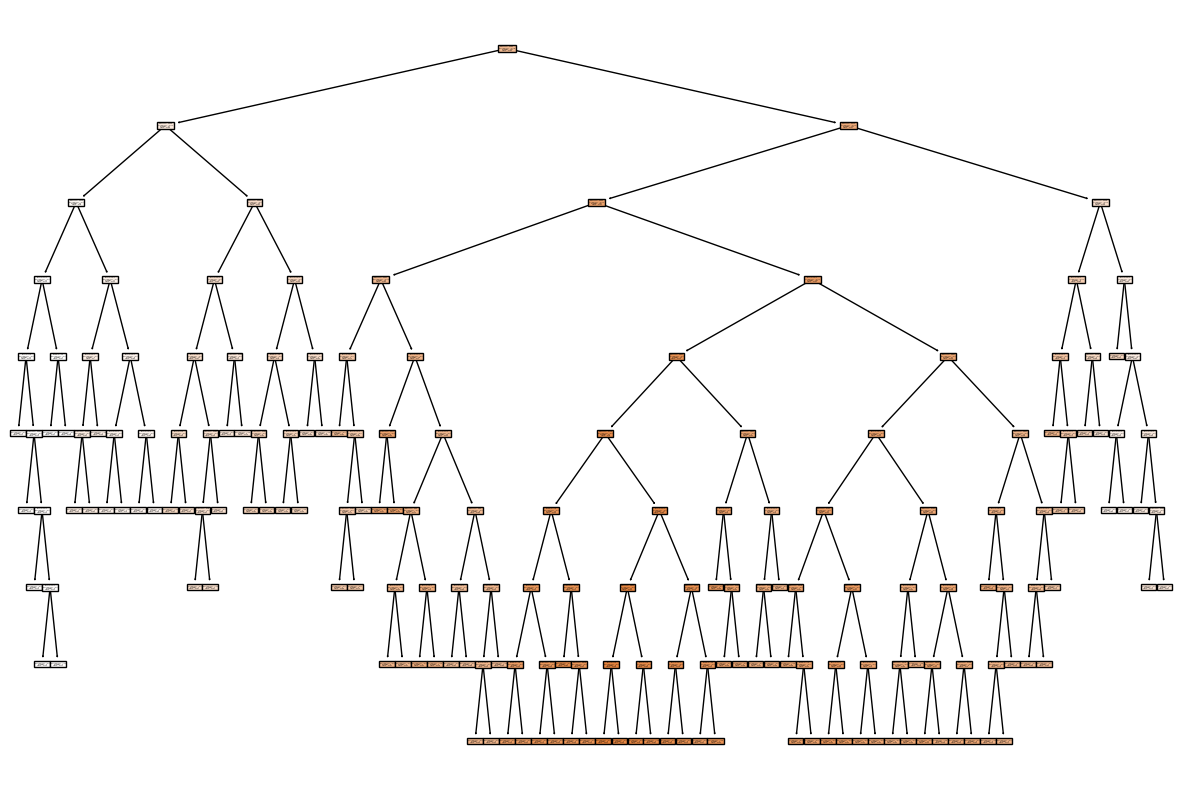

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


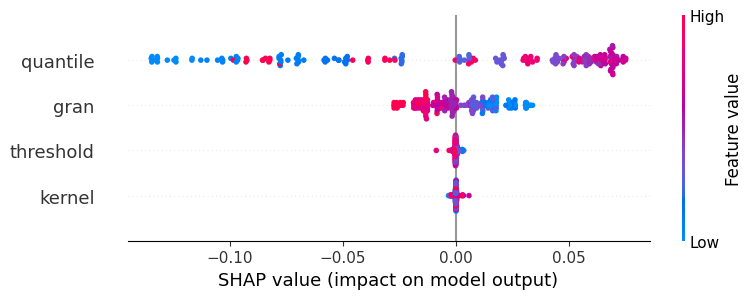

In [21]:


# 1. SHAP Summary Plot
shap.summary_plot(shap_values, X)

# 2. SHAP Dependence Plot for a specific feature (e.g., 'gran')
# shap.dependence_plot('gran', shap_values.values, X)

# # 3. SHAP Force Plot for a specific instance (e.g., the first instance)
# shap_instance = shap_values[0]
# shap.force_plot(explainer.expected_value, shap_instance.values, X.iloc[0])

# # 3.1 SHAP Force Plot for multiple instances (e.g., the first 5 instances)
# shap_instances = shap_values[:5]
# shap.force_plot(explainer.expected_value, shap_instances.values, X.iloc[:5])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


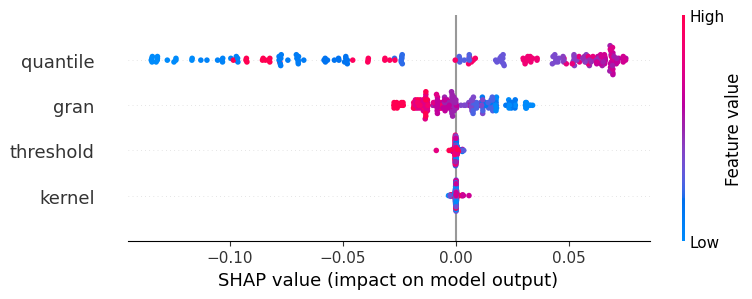

In [23]:
import matplotlib.pyplot as plt

# Create a matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Generate the SHAP summary plot and pass the ax object
shap.summary_plot(shap_values, X, plot_type='dot', show=False)

# Save the plot as a PDF
fig.savefig('shap_summary_plot.pdf', format='pdf', bbox_inches='tight')


In [ ]:
newres = results_df

In [ ]:
newres

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import random
from joblib import Parallel, delayed

# Your existing functions here

# ... (SQ and SCORE functions)

def calculate_f1(param_combination, data_key, data):
    DAT = data[data_key]
    f1 = SCORE(DAT, **param_combination)
    return f1

def random_search(params, data, num_data_points=100, max_iter=100, n_jobs=-1):
    results = []
    max_f1 = -np.inf
    best_params = None

    for _ in range(max_iter):
        param_combination = {key: random.choice(value) for key, value in params.items()}
        
        data_keys = list(data.keys())[:num_data_points]
        f1_scores = Parallel(n_jobs=n_jobs)(delayed(calculate_f1)(param_combination, data_key, data) for data_key in data_keys)
        
        avg_f1 = np.mean(f1_scores)
        
        param_combination["f1_score"] = avg_f1
        results.append(param_combination)

        if avg_f1 > max_f1:
            max_f1 = avg_f1
            best_params = param_combination

    return pd.DataFrame(results), best_params, max_f1

# Define the parameter search space
search_space = {
    'gran': np.arange(8, 20, 2),
    'kernel': np.arange(1, 5, 1),
    'quantile': np.linspace(0.5, 0.9, 5),
    'threshold': np.linspace(0.1, 0.3, 5),
}

max_iterations = 50
num_data_points = 100
results_df, best_params, best_f1 = random_search(search_space, data, num_data_points=num_data_points, max_iter=max_iterations)

print(f"Best parameters: {best_params}")
print(f"Best f1_score: {best_f1}")